Mounting Google Drive to Access Files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install required libraries

In [ ]:
# Install pyarrow for reading Parquet files
!pip install pyarrow

# Install Hugging Face libraries: transformers, datasets, and evaluate
!pip install -q transformers datasets evaluate


Imports

In [ ]:
# Data handling and numerical operations
import pandas as pd
import numpy as np

# PyTorch for deep learning
import torch

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Hugging Face tools for datasets and transformers
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

# Evaluation tools
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


Load alternate AG News Parquet files

In [ ]:
# Set file paths for training and test Parquet files stored in Google Drive
train_path = "/content/drive/MyDrive/Colab Notebooks/Ass_2/train-00000-of-00001 (2).parquet"
test_path = "/content/drive/MyDrive/Colab Notebooks/Ass_2/test-00000-of-00001 (1).parquet"

# Load the Parquet files into pandas DataFrames
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

# Print the number of samples in each dataset
print("Train Size:", len(train_df))
print("Test Size:", len(test_df))

# Display the first few rows of the training data
train_df.head()


Train Size: 120000
Test Size: 7600


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


Class labels

In [ ]:
# Define the names for each class label
label_names = ['World', 'Sports', 'Business', 'Sci/Tech']


EDA: Visualizing the Class Distribution with Counts on Bars

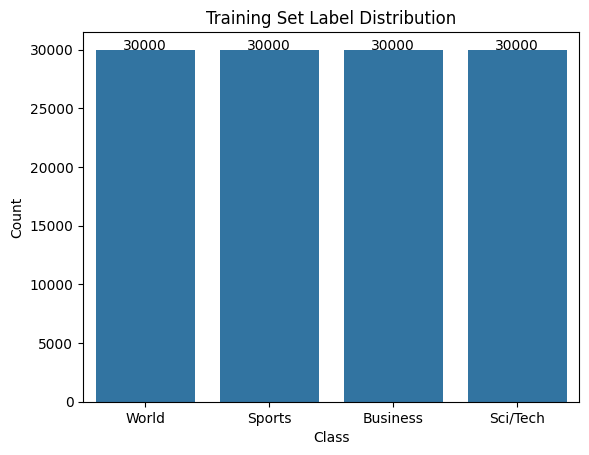

In [ ]:

# Plot the count of each class in the training data
ax = sns.countplot(x="label", data=train_df)
plt.title("Training Set Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1, 2, 3], labels=label_names)

# Add the exact count value on top of each bar for clarity
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5,  # 5 is vertical offset
            f'{int(height)}', ha="center")

plt.show()


Tokenizer

In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenize the text and cut off if too long
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


Convert to HF Dataset and tokenize

In [ ]:
# Change pandas data to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Apply tokenizer to the data in batches
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Load BERT model

In [ ]:
# Load pre-trained BERT with a classification head for 4 classes
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define accuracy metric

In [ ]:
# Load accuracy metric from evaluate library
accuracy = evaluate.load("accuracy")

# Define a function to compute accuracy from model predictions
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predicted class
    return accuracy.compute(predictions=predictions, references=labels)


Training arguments

In [ ]:
# Set training parameters:
# - Save and evaluate model after each epoch
# - Batch size of 16 for training and evaluation
# - Learning rate 2e-5
# - Train for 3 epochs
# - Apply weight decay for regularization
# - Load best model at the end
# - Disable external logging (like WandB)
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to=[]
)


In [ ]:
# Create a Trainer object to handle training and evaluation
# It uses the model, training arguments, datasets, padding, and metrics defined earlier
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)


Train the model

In [ ]:
# Start training the model using the Trainer
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.194600,0.176466,0.943553
2,0.126200,0.192912,0.948553
3,0.078600,0.238891,0.946053


TrainOutput(global_step=22500, training_loss=0.14797981804741753, metrics={'train_runtime': 1670.5377, 'train_samples_per_second': 215.499, 'train_steps_per_second': 13.469, 'total_flos': 1.7987934973367424e+16, 'train_loss': 0.14797981804741753, 'epoch': 3.0})

Evaluate on test set

In [ ]:
# Evaluate the trained model on the test dataset
metrics = trainer.evaluate(test_dataset)

# Print the accuracy score on the test data
print("Test Accuracy:", metrics["eval_accuracy"])


Test Accuracy: 0.9435526315789474


Predict on test set

In [ ]:
# Get model predictions on the test dataset
predictions = trainer.predict(test_dataset)
logits = predictions.predictions

# Convert logits to predicted class labels
predicted_labels = np.argmax(logits, axis=-1)

# Add predicted labels and class names to the test DataFrame
test_df["predicted_label"] = predicted_labels
test_df["predicted_class"] = test_df["predicted_label"].map(lambda x: label_names[x])
test_df["true_class"] = test_df["label"].map(lambda x: label_names[x])

# Display 10 random samples with their text, true class, and predicted class
test_df[["text", "true_class", "predicted_class"]].sample(10)


,text,true_class,predicted_class
7094,Fan v Fan: Manchester City-Tottenham Hotspur T...,Sports,Sports
1017,Paris Tourists Search for Key to 'Da Vinci Cod...,World,Sci/Tech
2850,Net firms: Don't tax VoIP The Spanish-American...,Sci/Tech,Sci/Tech
1452,Dependent species risk extinction The global e...,Sci/Tech,Sci/Tech
457,EDS Is Charter Member of Siebel BPO Alliance (...,Sci/Tech,Sci/Tech
6256,Campbell 9 Pct. Profit #39;Hmmm Hmmm Good #39...,Business,Business
6281,"Forgoing stiff upper lip, Charles jousts with ...",World,World
4999,Profit Plunges at International Game Tech Inte...,Business,Business
2941,Salvaging Genesis Despite a seemingly calamito...,Sci/Tech,Sci/Tech
408,Chavez rejects CD as opposition Venezuela #39;...,Business,World


Confusion matrix

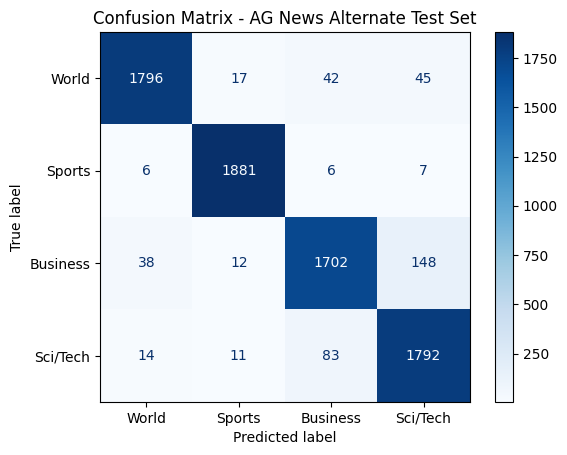

In [ ]:
# Compute the confusion matrix comparing true and predicted labels
cm = confusion_matrix(test_df["label"], test_df["predicted_label"])

# Create a plot for the confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

# Display the confusion matrix with a blue color map
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - AG News Alternate Test Set")
plt.show()
